In [33]:
import numpy as np
import matplotlib.pyplot as plt
import random
#from tqdm.notebook import trange

In [34]:
# Generate n numbers between 0 and 1 that sum to 1 uniformly at random
def uniform_random_prob_vector(n):
    k = np.random.exponential(scale=1.0, size=n)
    return k / sum(k)

In [35]:
# Sample a finite distribution of 0-(N-1) based on the given weights
def sample_dist(weights):
    weights = weights / sum(weights)
    r = np.random.rand()
    s = 0
    for i in range(len(weights)):
        if s <= r < s + weights[i]:
            return i
        s += weights[i]
    return len(weights) - 1

# Return n unique elements drawn from a distribution defined by the given weights
def sample_dist_unique(weights, n):
    if n > len(weights):
        raise Exception("can't do that")
    results = []
    while len(results) < n:
        draw = sample_dist(weights)
        if not (draw in results):
            results.append(draw)
    return results

In [36]:
# Given a list of lists, return the value of the first list with a single element
## returns none if no list has a single element
def first_unique_value(arr):
    for i in range(len(arr)):
        if len(arr[i]) == 1:
            return arr[i][0]
    return None

# Play a single round of LUPI with the given strategies, returns the winners index
def play_lupi(strats):
    guesses = [[] for _ in range(len(strats))]
    for i in range(len(guesses)):
        guesses[sample_dist(strats[i])].append(i)
    return first_unique_value(guesses)

# Plays a given number of rounds of LUPI with the given strat, returns the scores for each strat
def play_lupis(strats, rounds):
    num_players = len(strats[0])
    scores = np.zeros(num_players)
    for i in range(rounds):
        winner = play_lupi(strats)
        if winner is not None:
            scores[winner] += 1
    return scores

def element_occurances(ls, el):
    return len([x for x in ls if x == el])

In [37]:
# With a pair of neighbor probs starting a index, move val probability to the 
## left if direction < 0, and to the right if direction > 0
def spillover_mutation(probs, index, direction, val=0.01):
    direction = direction if direction else 2 * np.random.randint(2) - 1
    index = index if index else np.random.randint(len(probs) - 1)
    s = sum(probs)
    if direction < 0:
        probs[index] += min([s * val, probs[index + 1]])
        probs[index + 1] -= min([s * val, probs[index + 1]])
    else:
        probs[index + 1] += min([s * val, probs[index]])
        probs[index] -= min([s * val, probs[index]])
    return probs

# Switch the probability at index with the probability at index + 1
## if index is None, a random index is selected
def switch_mutation(probs, index):
    index = index if index else np.random.randint(len(probs) - 1)
    tmp = probs[index]
    probs[index] = probs[index + 1]
    probs[index + 1] = tmp
    return probs

# Return the average of 2 strategies
def breed_strategies(prob1, prob2):
    result = []
    for i in range(len(prob1)):
        result.append((prob1[i] + prob2[i]) / 2)
    return result / sum(result)

In [38]:
# A player in the LUPI game
class player:
    def __init__(self, n, palyer_id=None):
        self.strat = uniform_random_prob_vector(n)
        self.age = 0
        self.id = palyer_id
        self.score = 0        

# An evolving population of LUPI players
class LUPI_biosphere:
    def __init__(self, n, population_factor, param):
        self.next_id = 1
        self.n = n
        self.pop_factor = population_factor
        self.population = n * population_factor
        self.param = param
        self.players = [self.new_player() for _ in range(self.population)]
    
    # Return a new player with the next player id
    def new_player(self):
        p = player(self.n, self.next_id)
        self.next_id += 1
        return p
    
    # Remove the lowest-performing players from the population
    def cull(self):
        kill_total = int(self.param["cull_proportion"] * self.population)
        self.players = sorted(self.players, key=lambda p: p.score)
        self.players = self.players[kill_total:]
    
    # Add new players by breeding and mutating until the population is restored
    def repopulate(self):
        scores = np.array([p.score for p in self.players])
        while len(self.players) < self.population:
            # Select 2 unique players randomly (weighte by their fitness)
            p1_index, p2_index = sample_dist_unique(scores, 2)
            p1 = self.players[p1_index]
            p2 = self.players[p2_index]
            
            # Breed the players' strategies
            new_strat = breed_strategies(p1.strat, p2.strat)
            
            # Mutate
            if np.random.rand() > self.param["spillover_prob"]:
                new_strat = spillover_mutation(new_strat, None, None, self.param["spillover_val"])
            if np.random.rand() > self.param["switch_prob"]:
                new_probs = switch_mutation(new_strat, None)
            
            # Add a new player with the new strategy to the population
            p = self.new_player();
            p.strat = new_strat
            self.players.append(p)
    
    # Determine the fitness of each player
    def test_population(self):
        # Reset scores
        for p in self.players:
            p.score = 0
        for g in range(self.param["games_per_gen"]):
            random.shuffle(self.players)
            for i in range(self.pop_factor):
                players = self.players[self.n * i: self.n * (i+1)]
                strats = np.array([p.strat for p in players])
                winner = play_lupi(strats)
                if winner: 
                    players[winner].score += 1 / self.param["games_per_gen"]
            
    # For the specified number of iterations: test, cull, and repopulate.        
    def simulate(self, generations, callback=None):
        for _ in range(generations):
            for i in range(len(self.players)):
                self.players[i].age += 1
            self.test_population()
            if callback:
                callback(self)
            self.cull()
            self.repopulate()
        self.test_population()

In [39]:
def plot_ave_strat(players):
    strats = np.array([np.array(p.strat) for p in players])
    scores = np.array([p.score for p in players])
    ave = np.average(strats, 0, weights=(scores if not np.all(scores == 0) else None))
    x = list(range(len(strats[0])))
    plt.clf()
    plt.bar(x, ave)
    plt.title("Average Strategy")
    plt.show()
    
def plot_scores(players):
    scores = np.array([p.score for p in players if p.score != 0])
    ave = np.mean(scores)
    std = np.std(scores)
    plt.clf()
    plt.hist(scores)
    plt.title("Score Distribution (N: {}, Mean: {:.4f}, Std: {:.5f})".format(len(scores), ave, std))
    plt.show()
    
def print_best_player(players):
    p = max(players, key=lambda x: x.score)
    print("Best player info:")
    print("\tID: " + str(p.id))
    print("\tAge: " + str(p.age))
    print("\tScore: " + str(p.score))
    print("\tStrat: " + str(p.strat))
    x = list(range(len(p.strat)))
    plt.clf()
    plt.bar(x, p.strat)
    plt.title("Best Player's Strategy")
    plt.show()
    
def plot_prob_dist(players, prob_index):
    data = [p.strat[prob_index] for p in players]
    ave = np.mean(data)
    std = np.std(data)
    plt.clf()
    plt.hist(data, bins=40, range=(0,1))
    plt.title("P({}) Distribution (Mean: {:.4f}, Std: {:.5f})".format(prob_index, ave, std))
    plt.show()
    
def callback(sim):
    #plot_ave_strat(sim.players)
    #plot_scores(sim.players)
    plot_prob_dist(sim.players, 0)
    #print_best_player(sim.players)

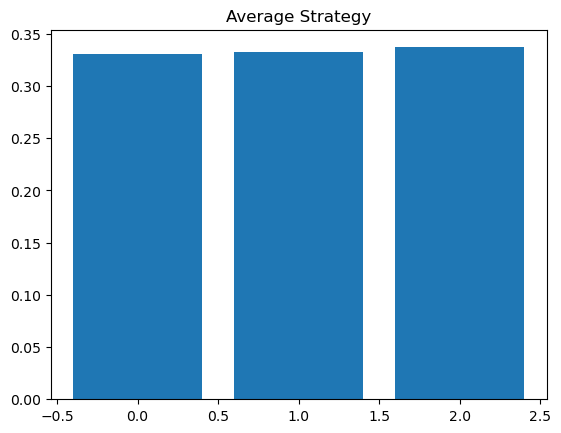

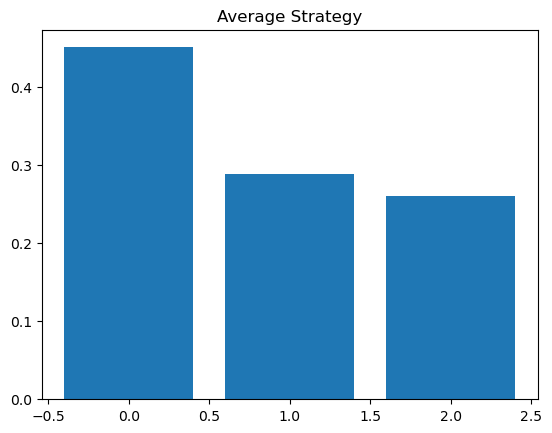

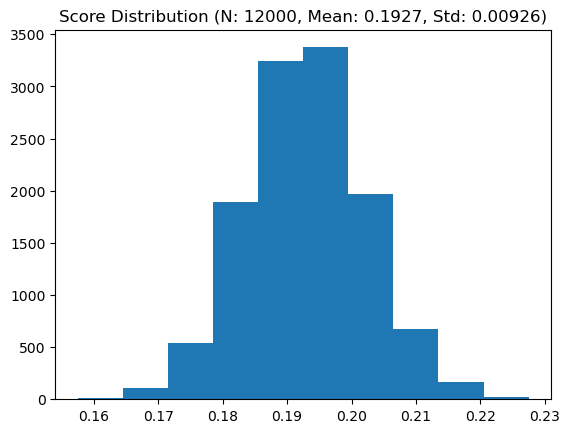

Best player info:
	ID: 124599
	Age: 6
	Score: 0.22750000000000017
	Strat: [0.60551263 0.2197133  0.17477407]


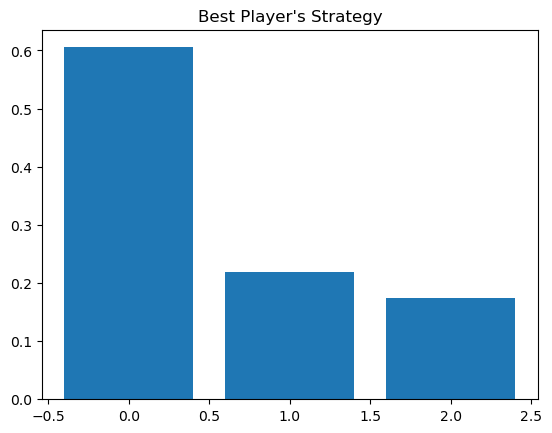

0.4641016151377544 0.2679491924311228 0.2679491924311228


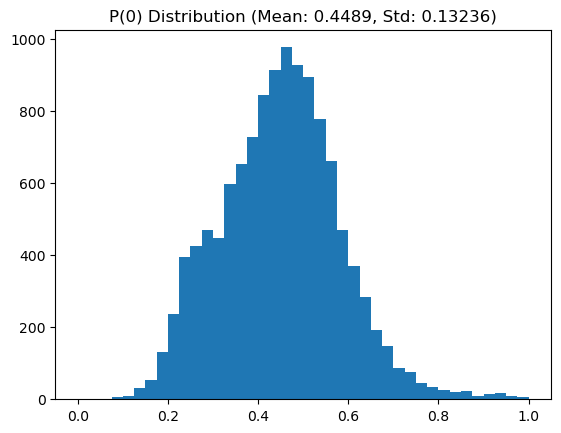

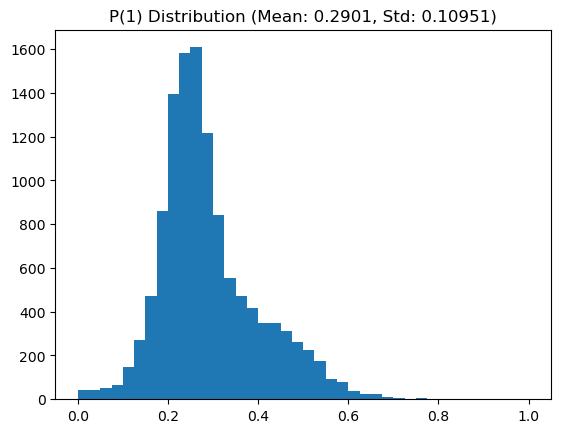

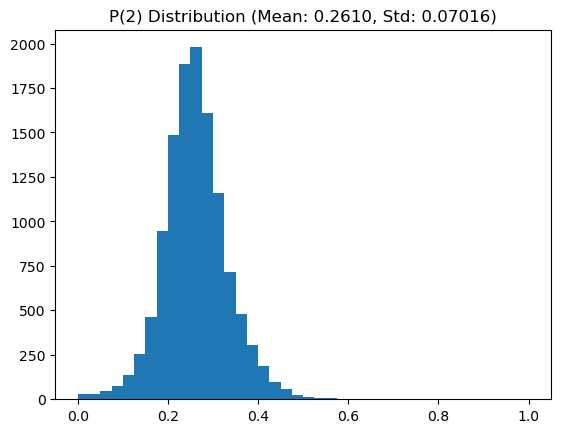

In [40]:
param = {"games_per_gen": 2000,
         "spillover_prob": 0.5,
         "spillover_val": 0.025,
         "switch_prob": 0.15,
         "cull_proportion": 0.1}

sim = LUPI_biosphere(3, 4000, param)
plot_ave_strat(sim.players)
sim.simulate(100)
plot_ave_strat(sim.players)
plot_scores(sim.players)
print_best_player(sim.players)
print(2*np.sqrt(3)-3, 2 - np.sqrt(3), 2-np.sqrt(3))
for i in range(3):
    plot_prob_dist(sim.players, i)

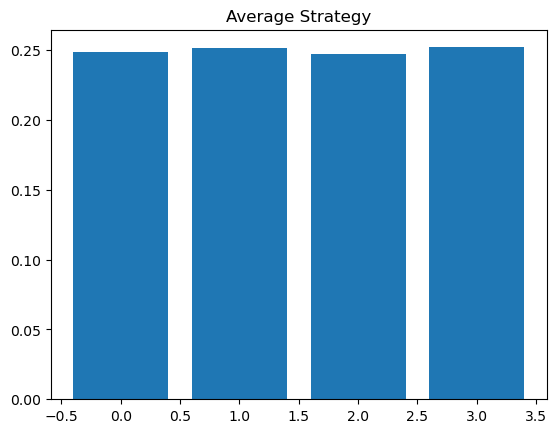

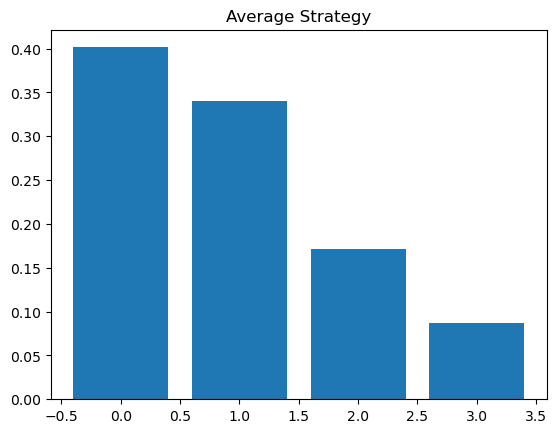

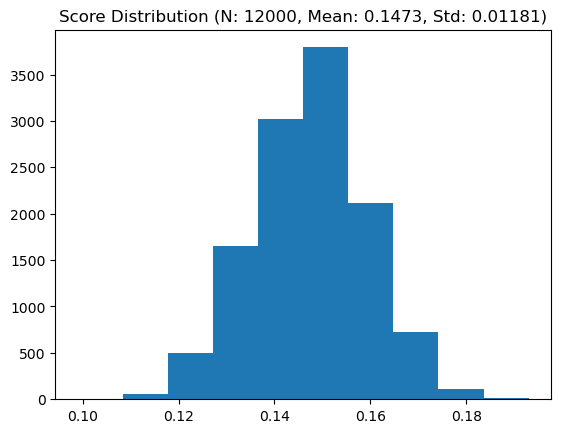

Best player info:
	ID: 111479
	Age: 17
	Score: 0.19300000000000014
	Strat: [0.41604078 0.34247873 0.17668001 0.06480047]


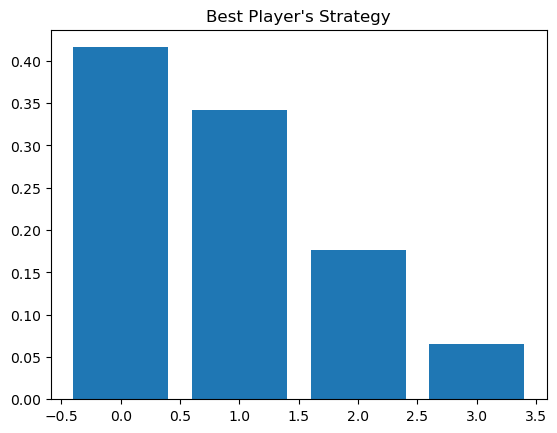

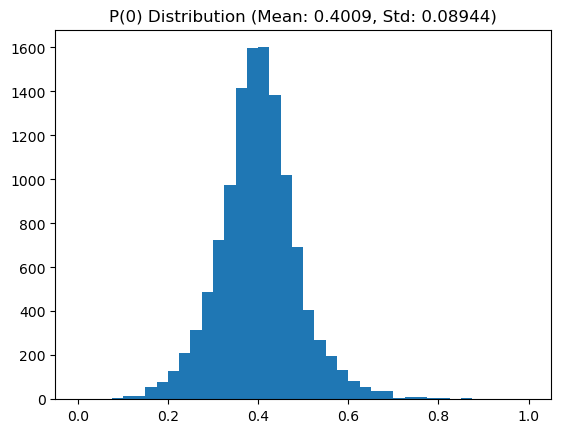

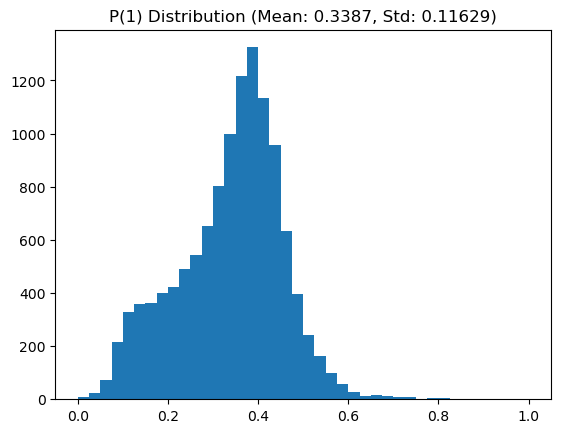

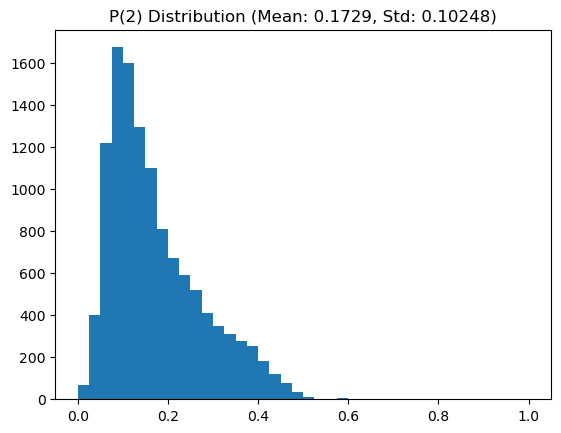

In [41]:
param = {"games_per_gen": 1000,
         "spillover_prob": 0.5,
         "spillover_val": 0.025,
         "switch_prob": 0.15,
         "cull_proportion": 0.1}

sim = LUPI_biosphere(4, 3000, param)
plot_ave_strat(sim.players)
sim.simulate(100)
plot_ave_strat(sim.players)
plot_scores(sim.players)
print_best_player(sim.players)
for i in range(4):
    plot_prob_dist(sim.players, i)